# Data Collection

Run this notebook to analyze new trials. Depends on the exact structure of the experiments results folder and specific file names, the constants should be changed in dataset.py or refactored to suit the new data structure or file names. 

In [2]:
import os
os.chdir('/app/Pogona_realtime/Arena')

In [3]:
import torch
import glob
import numpy as np
import imp
import matplotlib.pyplot as plt
import cv2 as cv
import pandas as pd
import pickle
import seaborn as sns
import imp
from IPython.display import display, HTML
from sklearn.mixture import GaussianMixture
from scipy import stats
import json
import shutil
import random
import re
import math
from datetime import datetime

from Prediction import dataset
from Prediction import predictor
from Prediction import detector
from Prediction.detector import Detector_v4
from Prediction import visualize
from Prediction import calibration as calib
from Prediction.kalman_predict import KalmanPredictor
from Prediction.predictor import HitPredictor
from Prediction.visualize import process_video, get_correction_fn, offline_predictor_visualizer
from Prediction import seq2seq_predict
from Prediction import train_eval

WEIGHTS_PATH = 'Prediction/Yolo4/yolo4_gs_best_2306.weights'
CFG_PATH = 'Prediction/Yolo4/yolo4_2306.cfg'

In [335]:
imp.reload(dataset)
imp.reload(calib)
imp.reload(visualize)

<module 'Prediction.visualize' from '/app/Pogona_realtime/Arena/Prediction/visualize.py'>

## Initialize YOLOv4 detector

In [18]:
det = Detector_v4(conf_thres=0.8)

Detector initiated successfully


## Analyze single trial

In [ ]:
dataset.analyze_rt_data('../../Pogona_Pursuit/Arena/output/feeding_4_20200830-125905', det)

## Analyze new trials

In [1]:
dataset.analyze_new_data(det)

NameError: name 'dataset' is not defined

In [125]:
# add a transformed csv where there's only an untransformed one.
dataset.save_transformed_data(trial_paths)

Saved transformed data to ../../Pogona_Pursuit/Arena/output/feeding_20200830-120813/rt_analysis/rt_trns.csv
Saved transformed data to ../../Pogona_Pursuit/Arena/output/feeding_4_20200830-121143/rt_analysis/rt_trns.csv
Saved transformed data to ../../Pogona_Pursuit/Arena/output/feeding_4_20200830-122515/rt_analysis/rt_trns.csv
Saved transformed data to ../../Pogona_Pursuit/Arena/output/feeding_4_20200830-125531/rt_analysis/rt_trns.csv
Saved transformed data to ../../Pogona_Pursuit/Arena/output/feeding_4_20200830-125905/rt_analysis/rt_trns.csv
Saved transformed data to ../../Pogona_Pursuit/Arena/output/feeding_4_screen_20200830-130446/rt_analysis/rt_trns.csv
Saved transformed data to ../../Pogona_Pursuit/Arena/output/feeding_5_20200830-131348/rt_analysis/rt_trns.csv
Saved transformed data to ../../Pogona_Pursuit/Arena/output/feeding_5_20200830-131916/rt_analysis/rt_trns.csv
Saved transformed data to ../../Pogona_Pursuit/Arena/experiments/line_20200803T082002/trial1/rt_analysis/rt_trns.cs

In [44]:
# copy vid_stat files from old folders to get old homography
for trial in trial_paths:
    old_vs = trial / "rt_data" / dataset.VID_STATS_FN
    new_vs = trial / dataset.RT_DATA_FOLDER / dataset.VID_STATS_FN
    
    if old_vs.exists():
        with open(old_vs, "r") as f:
            old_vid_stats = json.load(f)
        if "homography" in old_vid_stats:
            with open(new_vs, "r") as f:
                new_vid_stats = json.load(f)
            if "homography" not in new_vid_stats:
                shutil.copy(old_vs, new_vs)
                print("copied:", old_vs, "---->", new_vs)

# Load and merge data

In [339]:
trial_paths = dataset.select_analyzed_trials_paths()
trial_names = [dataset.trial_path_to_name(p) for p in trial_paths]
df = dataset.load_trial_data(trial_names)


Loaded 304 trials. 18 were not loaded.


(-1211.714399019876, 7126.336964349585, -1271.92993193949, 3936.8373040814686)

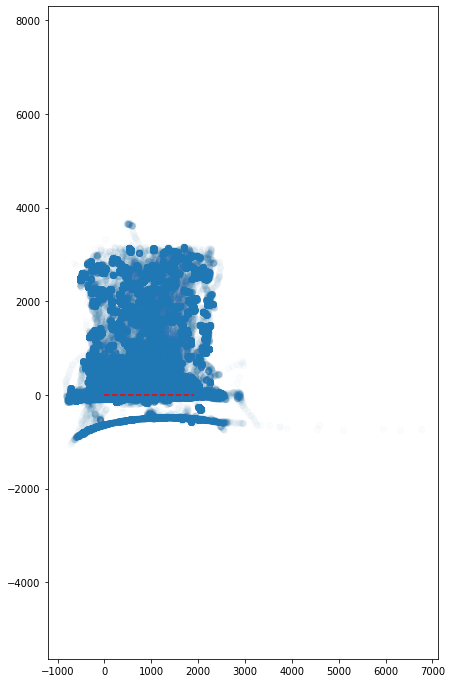

In [340]:
plt.figure(figsize=(7,12))
plt.scatter((df.x1 + df.x2)/2, df.y2,alpha=0.02)
plt.plot(np.linspace(0,1920,num=10),np.zeros(10),color='r',linestyle='--')
plt.axis('equal')

# Compare Camera Position

In [310]:
def find_last_trial_before_date(date):    
    trial_dates = pd.Series(list(map(dataset.get_date_from_path, trial_paths)))
    date_diffs = trial_dates - pd.to_datetime(date)
    dates_before = date_diffs <= pd.Timedelta(0)
    idx = date_diffs[dates_before].values.argmax()
    return trial_names[idx]

Text(0.5, 1.0, '../../Pogona_Pursuit/Arena/experiments/red_beetle_anticlock_20201104T145900/trial1/videos/realtime_20201104T145902.avi\n../../Pogona_Pursuit/Arena/experiments/red_beetle_20201101T145453/trial1/videos/realtime_20201101T145453.avi')

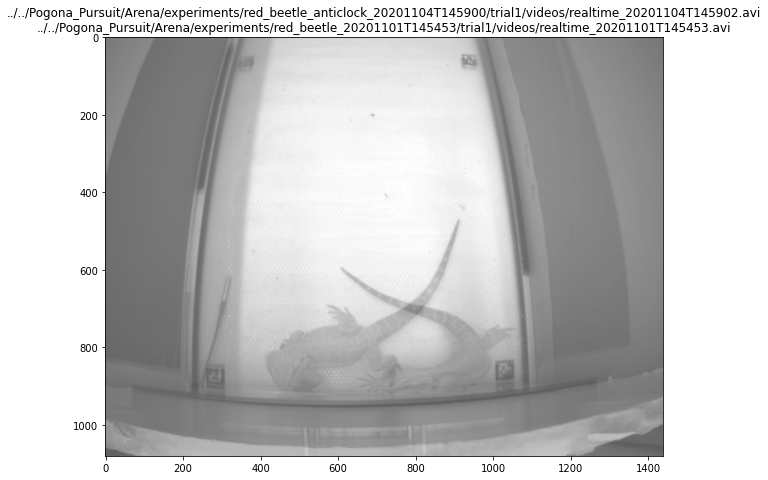

In [341]:
# 4/11 - dropped a bit
# 8/11 - droped again
ref_date = '2020-11-10'
check_date = '2020-11-02'

ref_trial = find_last_trial_before_date(np.datetime64(ref_date))
ref_vid = dataset.get_trial_video_path(ref_trial)

check_trial = find_last_trial_before_date(np.datetime64(check_date))
check_vid = dataset.get_trial_video_path(check_trial)

ref_frame = visualize.get_vid_frames(ref_vid, 0, 1)[0]
check_frame = visualize.get_vid_frames(check_vid, 0, 1)[0]

plt.figure(figsize=(10,10))
plt.imshow(ref_frame, alpha=0.5)
plt.imshow(check_frame, alpha=0.3)
plt.title(f"{ref_vid}\n{check_vid}")

In [174]:
# manual 4/11 corners
ps_0411 = [
    [1030, 914],
    [264, 936],
    [941, 28],    
    [342, 25]
]

In [175]:
h = calib.get_homography_from_points(ps_0411)

In [176]:
img_0411_trns = calib.transform_image(img_0411_ud, h)

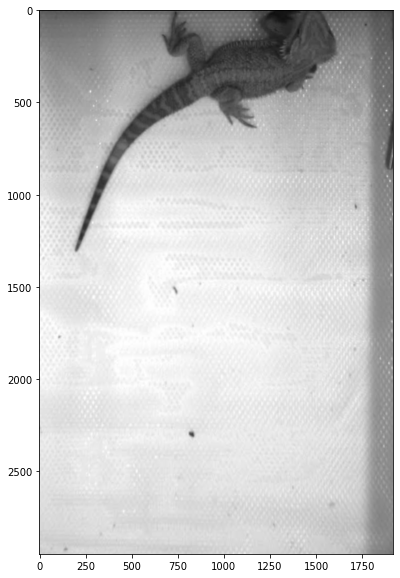

In [177]:
plt.figure(figsize=(10,10))
plt.imshow(img_0411_trns)

In [93]:
calib.save_homography(h, pd.datetime.now(), 1440, 1080)

/home/user/miniconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """Entry point for launching an IPython kernel.


In [7]:
def trials_on_day(date):    
    trial_dates = list(map(dataset.get_date_from_path, trial_names))
    def trial_date_equals(trial_name):
        td = dataset.get_date_from_path(trial_name)
        return pd.to_datetime(td).date() == pd.to_datetime(date).date()
    return list(filter(trial_date_equals, trial_names))

In [8]:
trials0411 = trials_on_day(np.datetime64("2020-11-04"))
trials0411_paths = list(map(dataset.get_trial_path, trials0411))

In [230]:
vid_width = 1440
vid_height = 1080

for trial_path in trials0411_paths:
    rt_data_path = os.path.join(trial_path, dataset.RT_DATA_FOLDER)
    json_fn = os.path.join(rt_data_path, dataset.VID_STATS_FN)
    homography, calib_path = dataset.find_last_homography(os.path.split(trial_path)[0])
    with open(json_fn, "w") as fp:
        vid_stats = {
            "width": vid_width,
            "height": vid_height,
            "homography": homography.tolist(),
            "homography_src_file": calib_path,
        }

        json.dump(vid_stats, fp)


(-597.5918135603962,
 2039.885324455257,
 -1054.6716656590409,
 2642.9319089966307)

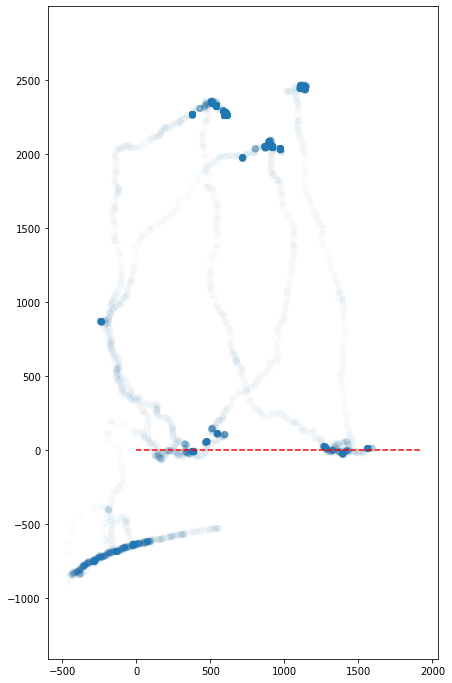

In [302]:
trials0411_tuples = list(map(dataset.trial_name_to_tuple, trials0411))
# df = all_df.loc[trials_on_day(np.datetime64("2020-11-01")), :]
day_trials = trials_on_day(np.datetime64("2020-11-01"))
df = all_df.loc[day_trials[1]]
plt.figure(figsize=(7,12))
plt.scatter(df.cent_x,df.y2,alpha=0.02)
plt.plot(np.linspace(0,1920,num=10),np.zeros(10),color='r',linestyle='--')
plt.axis('equal')

In [279]:
trials1101 = trials_on_day(np.datetime64("2020-11-01"))

red_beetle_circle_20201101T132007/trial2


(array([[2455],
        [2542],
        [3207],
        [3223],
        [5574],
        [5795],
        [5826],
        [5929]]),
 array([], shape=(0, 1), dtype=int64))

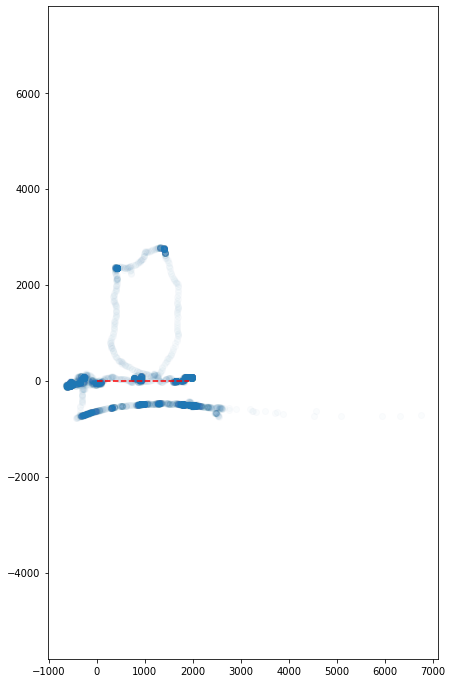

In [227]:
trial = 'red_beetle_circle_20201101T132007/trial2'
plt.figure(figsize=(7,12))
plt.scatter((df.loc[trial].x1 + df.loc[trial].x2)/2,df.loc[trial].y2,alpha=0.02)
plt.plot(np.linspace(0,1920,num=10),np.zeros(10),color='r',linestyle='--')
plt.axis('equal')
print(trial)
np.argwhere(df.loc[trial].is_touch.values), np.argwhere(df.loc[trial].is_hit.values)

# Find touches and generate data video

In [233]:
def gen_trial_video(trial, 
                    df, 
                    start_frame=0, 
                    end_frame=None, 
                    past_color=(255, 0, 0), 
                    future_color=(0, 0, 255), 
                    dot_radius=4, 
                    line_thickness=2,
                    video_width=1280,
                    out_path_prefix="data"):

    vid_path = dataset.get_trial_video_path(trial)
    out_path = f'../labelled/{trial.replace("/", "_")}_{out_path_prefix}.mp4'
    homography, _ = dataset.find_last_homography(dataset.get_trial_path(trial).parent)
    correction_fn = visualize.get_correction_fn(homography,1920)
    tdf = df.loc[trial]
    
    bboxes = tdf[['x1', 'y1', 'x2', 'y2']].values
    hits = tdf['is_hit']
    touches = tdf['is_touch']
    touch_xs = tdf['touch_x']
    bug_x = tdf['bug_x']


    num_frames = end_frame - start_frame if end_frame is not None else None

    visualize.process_video(
        video_path=vid_path,
        output_path=out_path,
        process_fns=(
            [visualize.offline_bug_visualizer(bug_x),
             visualize.offline_touch_visualizer(touches, hits, touch_xs),
             visualize.offline_trajectory_visualizer(
                 bboxes,
                 past_color=past_color,
                 future_color=future_color,
                 dot_radius=dot_radius,
                 past_length=20,
                 future_length=20
             ),
             visualize.offline_bbox_visualizer(
                 bboxes, 
                 color=(0, 0, 0), 
                 line_thickness=line_thickness,
                 window_size=1
             ),
             visualize.offline_centroid_visualizer(
                 bboxes, 
                 color=(0, 0, 0), 
                 dot_radius=dot_radius*2,
                 window_size=1
             )
            ]),
        correction_fn=correction_fn,
        start_frame=start_frame,
        num_frames=num_frames,
        resize_to_width=video_width
    )

In [246]:
# touches per trial
for trial in df.index.unique():
    touch_count = sum(df.loc[trial].is_touch)
    if touch_count > 0:
        print(f"{trial}: {touch_count}")

fast_line_20200803T082414/trial1: 2
fast_line_20200803T082724/trial1: 1
fast_cockroach_20200803T085738/trial1: 5
circle_20200803T090234/trial1: 1
circle_20200803T091639/trial1: 7
circle_20200803T092248/trial1: 1
line_20200803T114942/trial1: 2
circle_20200803T115839/trial1: 11
circle_20200803T120911/trial1: 2
red_beetle_20200826T133947/trial1: 1
worm_20200826T134603/trial1: 1
worm_20200826T135440/trial1: 1
worm_20200826T135440/trial2: 1
worm_line_20200830T121825/trial1: 1
worm_circle_20200830T122241/trial1: 1
learning_20200917T081521/trial2: 1
learning_20200917T081521/trial3: 1
learning_20200917T084025/trial1: 1
learning_20200917T084025/trial2: 1
learning_20200917T092820/trial3: 1
learning_20200917T150415/trial1: 1
learning_20200917T150415/trial3: 2
learning_20200917T152238/trial1: 1
learning_20200917T152238/trial2: 1
learning_20200917T154539/trial2: 1
learning_20200917T154539/trial3: 1
learning_20201001T081837/trial1: 2
learning_20201001T081837/trial2: 1
learning_20201001T081837/trial4

In [259]:
trial = "red_beetle_circle_20201101T132007/trial5"
tdf = df.loc[trial]
tdf[tdf.is_touch]

,Unnamed: 0,frame_ts,x1,y1,x2,y2,conf,num_bbox,touch_x,touch_y,bug_x,bug_y,is_touch,is_hit,touch_ts,bug_ts
red_beetle_circle_20201101T132007/trial5,2977,2020-11-01 15:55:18.955811501+02:00,388.144528,192.085218,92.671248,-40.378218,0.992613,1.0,434.0,161.0,NaN,NaN,True,False,2020-11-01 15:55:18.962000+02:00,NaN
red_beetle_circle_20201101T132007/trial5,2991,2020-11-01 15:55:19.194148302+02:00,331.537871,219.965218,-18.032415,-64.088655,0.987575,1.0,382.0,115.0,NaN,NaN,True,False,2020-11-01 15:55:19.194000+02:00,NaN
red_beetle_circle_20201101T132007/trial5,3235,2020-11-01 15:55:23.347920418+02:00,1321.978541,270.779167,1051.527431,-3.383985,0.993952,1.0,1400.0,471.0,1210.105322,220.748415,True,False,2020-11-01 15:55:23.342000+02:00,2020-11-01 15:55:23.347000+02:00
red_beetle_circle_20201101T132007/trial5,3769,2020-11-01 15:55:32.438563585+02:00,1799.892432,224.079607,1479.807352,-16.248297,0.995375,1.0,1716.0,362.0,828.806916,389.232289,True,False,2020-11-01 15:55:32.444000+02:00,2020-11-01 15:55:32.435000+02:00
red_beetle_circle_20201101T132007/trial5,3794,2020-11-01 15:55:32.864142895+02:00,1820.346353,251.276594,1509.278462,-2.615110,0.987027,1.0,2186.0,693.0,912.549159,324.327747,True,False,2020-11-01 15:55:32.859000+02:00,2020-11-01 15:55:32.851000+02:00
red_beetle_circle_20201101T132007/trial5,3843,2020-11-01 15:55:33.698307037+02:00,1932.344325,266.621576,1627.570736,-13.264504,0.992115,1.0,2290.0,578.0,1105.733413,238.965650,True,False,2020-11-01 15:55:33.694000+02:00,2020-11-01 15:55:33.683000+02:00
red_beetle_circle_20201101T132007/trial5,3866,2020-11-01 15:55:34.089871168+02:00,1945.434659,265.245105,1563.786794,3.805316,0.991115,1.0,2348.0,686.0,1205.881801,221.150665,True,False,2020-11-01 15:55:34.095000+02:00,2020-11-01 15:55:34.083000+02:00
red_beetle_circle_20201101T132007/trial5,3885,2020-11-01 15:55:34.413332224+02:00,1917.782678,309.305265,1544.562672,-26.562156,0.987252,1.0,2032.0,675.0,1286.387096,218.205336,True,False,2020-11-01 15:55:34.419000+02:00,2020-11-01 15:55:34.403000+02:00
red_beetle_circle_20201101T132007/trial5,4036,2020-11-01 15:55:36.983914852+02:00,2070.908681,230.648735,1758.402305,-1.724648,0.994143,1.0,1913.0,149.0,1830.868107,535.632692,True,False,2020-11-01 15:55:36.991000+02:00,2020-11-01 15:55:36.979000+02:00
red_beetle_circle_20201101T132007/trial5,4138,2020-11-01 15:55:38.720331907+02:00,2107.774718,321.857825,1775.493192,0.179257,0.991595,1.0,2401.0,577.0,NaN,NaN,True,False,2020-11-01 15:55:38.721000+02:00,NaN


In [260]:
gen_trial_video(trial, 
                df,
                start_frame=4000, 
                end_frame=4200, 
                out_path_prefix="touches")

# Weird Trials
- 'red_beetle_20201101T145453_trial1' - touch_x doesn't seem to be correct at hit time.
- CategoricalIndex(['red_beetle_circle_20201101T132007/trial2', 'red_beetle_20201101T143002/trial3'], categories=['red_beetle_circle_20201101T132007/trial2', 'red_beetle_20201101T143002/trial3'], ordered=False, dtype='category') <-- THESE HAVE VERY LARGE X1 values

In [9]:
trials0411

['anti-circle_20201104T142037_trial1',
 'anti-circle_20201104T142503_trial1',
 'red_beetle_circle_20201104T143818_trial1',
 'red_beetle_anticlock_20201104T145900_trial1']

In [12]:
trials0111 = trials_on_day(pd.Timestamp(2020, 11, 1))

In [17]:
trial = "circle_20200803T120911/trial1"

In [43]:
dataset.get_trial_path(trial)

PosixPath('../../Pogona_Pursuit/Arena/experiments/circle_20200803T120911/trial1')

In [187]:
df[df.is_touch].shape[0]

(351, 16)

In [203]:
df[df.x1>3000].index.unique()

CategoricalIndex(['red_beetle_circle_20201101T132007/trial2',
                  'red_beetle_circle_20201101T132007/trial5',
                  'red_beetle_circle_20201101T132007/trial6',
                  'red_beetle_20201101T143002/trial3'],
                 categories=['red_beetle_circle_20201101T132007/trial2', 'red_beetle_circle_20201101T132007/trial5', 'red_beetle_circle_20201101T132007/trial6', 'red_beetle_20201101T143002/trial3'], ordered=False, dtype='category')

# Notes
- need to analyze '../../Pogona_Pursuit/Arena/output/feeding_20200830-115520/rt_analysis/vid_stats.json'
- and also two lines from same time 